# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
pip install scikit-learn

In [3]:
pip install palmerpenguins

In [4]:
# ================================
# SECTION 1 — Import, Clean, Dummify
# ================================

import pandas as pd
import numpy as np
import palmerpenguins
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Load dataset
penguins = palmerpenguins.load_penguins().dropna()

# Predictors (everything except species)
X = penguins.drop(columns=["species"])

# Target variable (species)
y = penguins["species"]

# Categorical & numerical predictors
cat_cols = ["island", "sex"]
num_cols = ["bill_length_mm", "bill_depth_mm",
            "flipper_length_mm", "body_mass_g", "year"]

# Preprocessing: dummify categoricals + scale numerics
ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="drop"
)

# Stratified train-test split (important for classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training Set Species Counts:")
print(y_train.value_counts())
print("\nTest Set Species Counts:")
print(y_test.value_counts())


Training Set Species Counts:
species
Adelie       109
Gentoo        89
Chinstrap     51
Name: count, dtype: int64

Test Set Species Counts:
species
Adelie       37
Gentoo       30
Chinstrap    17
Name: count, dtype: int64


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.


MODEL PERFORMANCE SUMMARY:

kNN (k=3)
  Accuracy: 0.976
  Precision: 0.971
  Recall: 0.971
  F1: 0.971
  AUC: 1.000

kNN (k=10)
  Accuracy: 1.000
  Precision: 1.000
  Recall: 1.000
  F1: 1.000
  AUC: 1.000

Decision Tree (depth=3)
  Accuracy: 0.964
  Precision: 0.975
  Recall: 0.958
  F1: 0.965
  AUC: 0.974

Decision Tree (depth=7)
  Accuracy: 0.976
  Precision: 0.983
  Recall: 0.978
  F1: 0.980
  AUC: 0.982


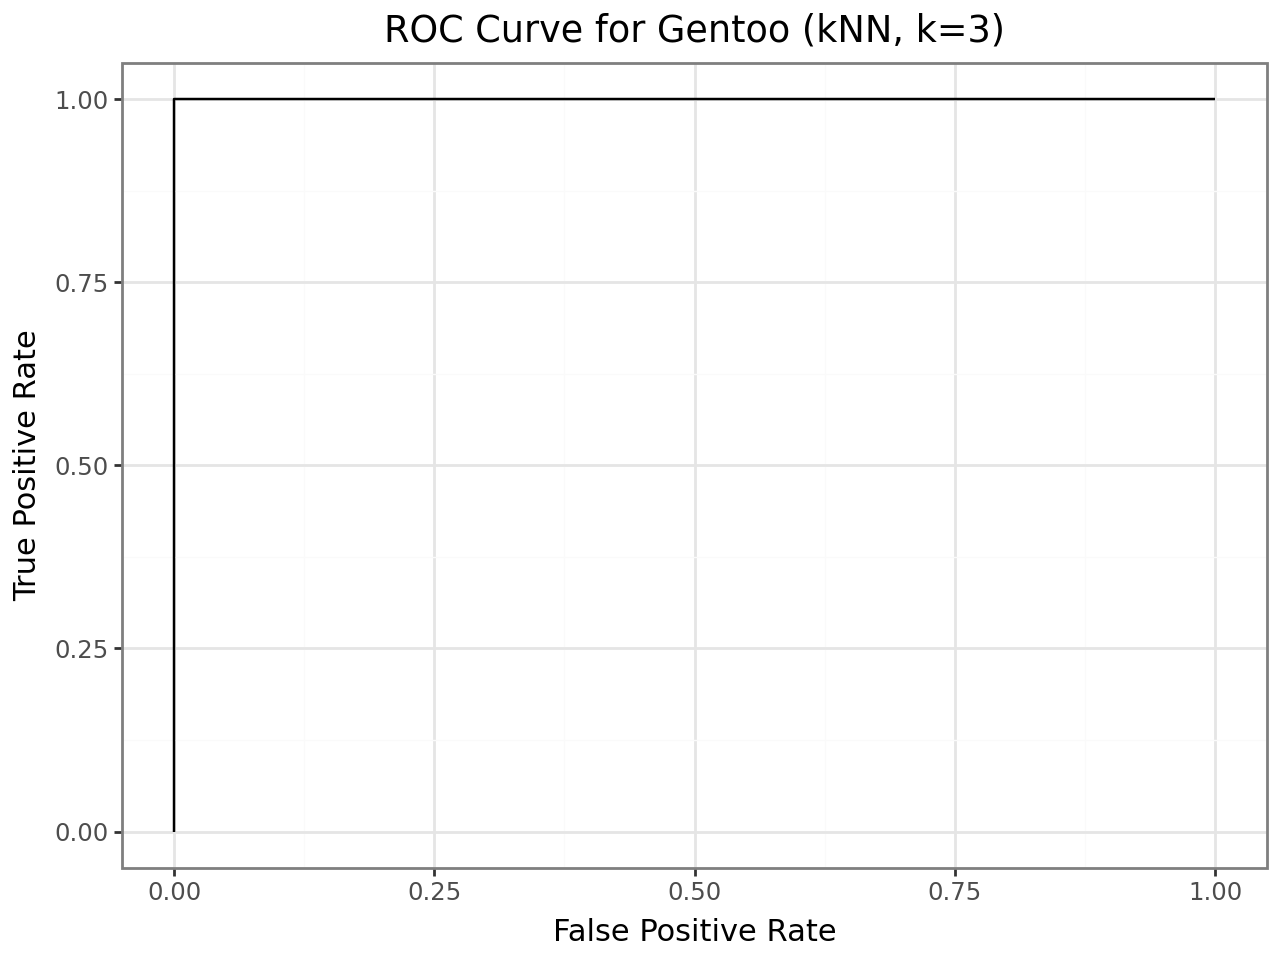

In [5]:
# ================================
# SECTION 2 — Models, Metrics, ROC
# ================================

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from plotnine import ggplot, aes, geom_line, labs, theme_bw

models = {
    "kNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "kNN (k=10)": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree (depth=3)": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Decision Tree (depth=7)": DecisionTreeClassifier(max_depth=7, random_state=42)
}

results = {}

# Loop through models and compute metrics
for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", ct),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)

    # Overall accuracy
    acc = accuracy_score(y_test, preds)

    # Macro-averaged metrics for multiclass
    precision = precision_score(y_test, preds, average="macro")
    recall = recall_score(y_test, preds, average="macro")
    f1 = f1_score(y_test, preds, average="macro")

    # Multiclass AUC (one-vs-rest)
    auc = roc_auc_score(y_test, probs, multi_class="ovr")

    results[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

# Print summary
print("\nMODEL PERFORMANCE SUMMARY:")
for name, metrics in results.items():
    print(f"\n{name}")
    for metric_name, val in metrics.items():
        print(f"  {metric_name}: {val:.3f}")

# ================================
# ROC Curve for ONE species (Gentoo)
# ================================

# Choose species for binary ROC
target_species = "Gentoo"

pipe_roc = Pipeline([
    ("preprocess", ct),
    ("clf", KNeighborsClassifier(n_neighbors=3))
])

pipe_roc.fit(X_train, y_train)

# Extract probability for Gentoo
probs = pipe_roc.predict_proba(X_test)
gentoo_index = list(pipe_roc.named_steps["clf"].classes_).index("Gentoo")
gentoo_prob = probs[:, gentoo_index]

# Convert to binary 1 = Gentoo
y_binary = (y_test == target_species).astype(int)

# ROC curve
fpr, tpr, _ = roc_curve(y_binary, gentoo_prob)

df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr})

(
    ggplot(df_roc, aes(x="fpr", y="tpr"))
    + geom_line()
    + labs(
        title="ROC Curve for Gentoo (kNN, k=3)",
        x="False Positive Rate",
        y="True Positive Rate"
    )
    + theme_bw()
)
